# GMRES

GMRES is simply the replacement of the problem "solve $b-Ax=0$ with "minimize $\|b-Ax\|$ over $\mathcal{K}_n$". Its convergence depends strongly on (at least) the spectrum of $A$.

This example is adapted from the text.

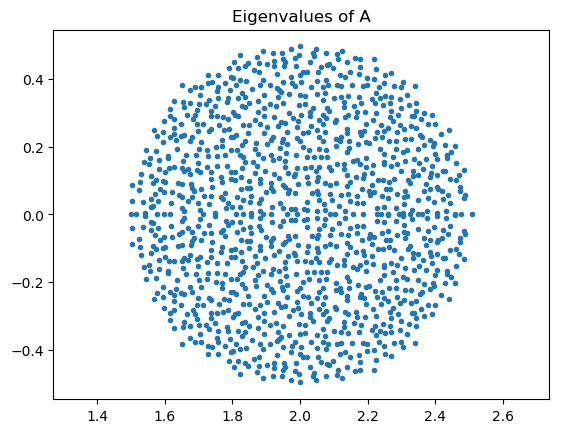

In [1]:
using LinearAlgebra,PyPlot

m = 1200;
A = 2I + 0.5*randn(m,m)/sqrt(m);
lam = eigvals(A);
plot(real(lam),imag(lam),".");
axis("equal");
title("Eigenvalues of A");

Here's the Arnoldi iteration again.

In [2]:
function arnoldi(A,nmax)
    m = size(A,1)
    Q = zeros(m,nmax+1);
    H = zeros(nmax+1,nmax);
    Q[:,1] = b/norm(b);
    for n = 1:nmax
        v = A*Q[:,n]
        for i = 1:n
            H[i,n] = Q[:,i]'*v
            v = v - H[i,n]*Q[:,i]
        end
        H[n+1,n] = norm(v);
        Q[:,n+1] = v/H[n+1,n];
    end
    return H,Q
end

arnoldi (generic function with 1 method)

All we need to do is use the information after each $n$ to solve the least squares problem min $\|b-Ax\|=\|Q_n^*b-H_n z\|$, in which $x=Q_nz$. Furthermore, $Q_n^*b=\|b\|e_1$. 

In [3]:
function gmres(A,b,nmax)
    m = size(A,1)
    Q = zeros(eltype(A),m,nmax+1);
    H = zeros(eltype(A),nmax+1,nmax);
    nrmb = norm(b)
    Q[:,1] = b/nrmb
    resnorm = zeros(nmax)
    for n = 1:nmax
        v = A*Q[:,n]
        for i = 1:n
            H[i,n] = Q[:,i]'*v
            v = v - H[i,n]*Q[:,i]
        end
        H[n+1,n] = norm(v);
        Q[:,n+1] = v/H[n+1,n];
        
        Qtb = [nrmb;zeros(n)]
        global z = H[1:n+1,1:n] \ Qtb
        resnorm[n] = norm( H[1:n+1,1:n]*z - Qtb ) / nrmb
    end
    x = Q[:,1:nmax]*z
    return x,resnorm
end

gmres (generic function with 1 method)

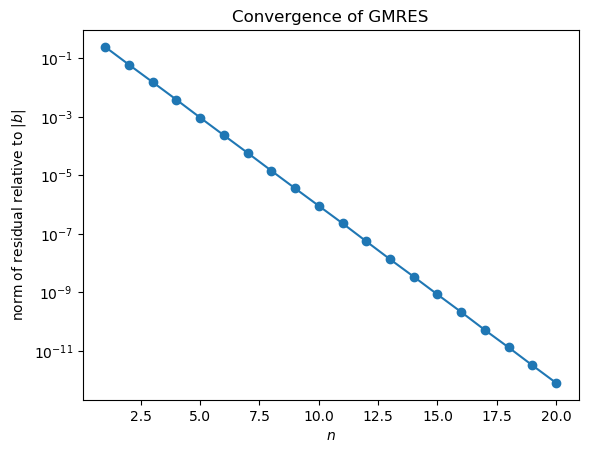

In [4]:
b = ones(m)
x,resnorm = gmres(A,b,20)
semilogy(1:20,resnorm,"o-");
xlabel(L"$n$"), ylabel(L"norm of residual relative to $\|b\|$");
title("Convergence of GMRES");

The text explains why this curve might be very close to $4^{-n}$. 

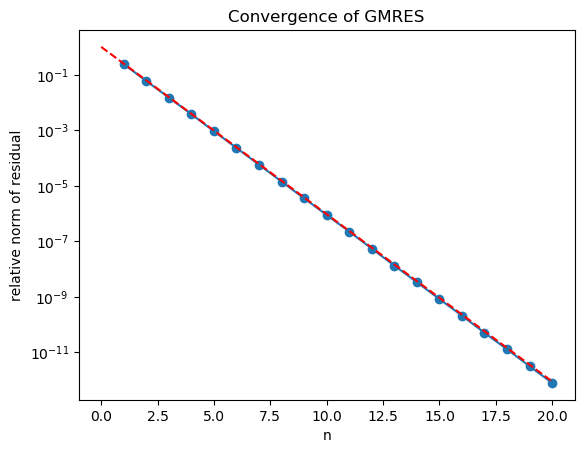

In [5]:
semilogy(1:20,resnorm,"o-");
semilogy(0:20,.25 .^(0:20),"r--");
xlabel("n"), ylabel("relative norm of residual");
title("Convergence of GMRES");

The rate is tied to how easy it is to make a polynomial small on the spectrum of $A$ while satisfying the normalization $p(0)=1$. If the eigenvalues get close to or surround the origin, this becomes difficult.

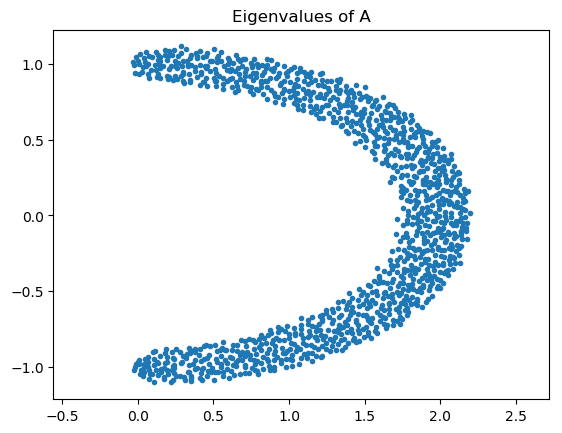

In [6]:
theta = pi*(0:m-1)/(m-1)
d = @. (-2+2*sin(theta)) + 1im*cos(theta)
D = Diagonal(d)
A = A + D
lam = eigvals(A)
plot(real(lam),imag(lam),".")
axis("equal") 
title("Eigenvalues of A");

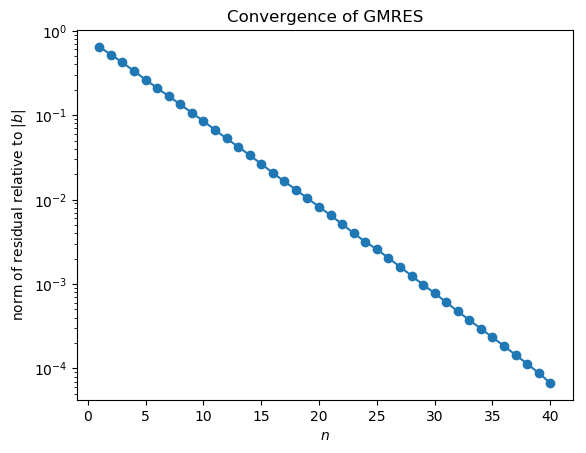

In [7]:
b = ones(m,1);
x,resnorm = gmres(A,b,40)
semilogy(1:40,resnorm,"o-");
xlabel(L"$n$"), ylabel(L"norm of residual relative to $\|b\|$");
title("Convergence of GMRES");

There is again a linear convergence rate, but a much slower one this time due to the shape of the spectrum.